## What's a WebHook?
What a fantastic question. A webhook is a way for an application or service to provide real-time notifications to another application or service by sending HTTPS requests to a specific URL (known as the webhook endpoint) when a specific event or trigger occurs. In layman's terms, it lets you know when something tied to a specific endpoint happens. They're an extremely useful tool for automation in workflows involving APIs and/or web-based applications.

For Example: we want to keep track of a delete protected service and if something occurs where it gets accidentally deleted, we can trigger a script to be run to reinstate the service. That's not the example we're going to do, but it'd be pretty neat.

# How is it useful to admins?
  
  By leveraging webhooks, an ArcGIS Online admin can streamline workflows, automate processes, and enhance integration with external systems. The specific use cases and implementations will depend on the requirements and objectives of your organization. For your convenience, here's the [link to the module pages in our API documentation.](https://developers.arcgis.com/python/api-reference/arcgis.features.managers.html#webhookservicemanager)

> ## WebHookServiceManager
> This manager is used for working with feature service-specific events in the ArcGIS API for Python. It allows owners and administrators to wire feature service events to a FeatureLayerCollection object. It is primarily focused on managing webhooks related to feature service events, such as when features are added, updated, or deleted. [Here are all the service webhook event types.](https://developers.arcgis.com/rest/services-reference/online/web-hooks-create-feature-service-.htm)
  
    
> ## WebHookManager
> This manager enables you to receive notifications for events associated with items, groups, and users within your ArcGIS Organization environment. It allows you to configure webhooks for various events, including item creation, deletion, modification, user authentication events, and more. [Here are all the webhook event types.](https://developers.arcgis.com/rest/users-groups-and-items/create-webhooks/)

## Monitoring daily edits to a time-enabled feature layer

Alright, so we started broad, and now we get specific. We're going to do a sample workflow that will touch upon webhooks and then scheduling tasks, which will be our next section.

One of the niftiest things about working with ArcGIS Online or Enterprise is access to the [Living Atlas](https://livingatlas.arcgis.com/en/home/)- a massive catalog of publicly available data from all sorts of sources. We'll show how you can use the tools available through Online administration to enhance your experience with the Living Atlas.

We have a Living Atlas item that shows the position of the Gulf Stream every day, but no aggregated historical data on it- what if we wanted to take that position every day and add it to a feature layer we store in our own org? That way, we can maintain a record of how it shifts on a daily basis, and leverage the map viewer's compatibility with time-enabled data to visually show its shifts.

#### Gulf Stream, here we come

In [2]:
# necessary imports and connect to our online org
from arcgis.gis import GIS
from arcgis.features.managers import WebHookEvents

gis = GIS(profile="your_online_profile")

<Item title:"Gulf Stream Boundary" type:Feature Layer Collection owner:esri_oceans>
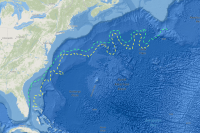

In [3]:
# here's the daily gulf stream layer
gis.content.get("723cfc2ce60f4fc88a7c51e9905acb70")

<Item title:"Time Enabled Gulf Stream Layer" type:Feature Layer Collection owner:nparavicini_geosaurus>
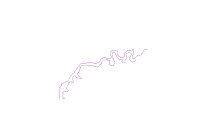

In [4]:
# here's our own aggregated feature layer that we've been adding to
gulf_layer = gis.content.get("cc1f8377231b4247b5085e89635dc537")
gulf_layer

To work with service webhooks in the Python API, we first have to create a Feature Layer Collection object.

In [5]:
flc = gulf_layer.layers[0].container
flc

<FeatureLayerCollection url:"https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/a7998a/FeatureServer">

In [6]:
# let's take a look at the properties
flc.manager.properties

{
  "adminServiceInfo": {
    "name": "a7998a",
    "type": "FeatureServer",
    "cacheMaxAge": 0,
    "status": "Started",
    "database": {
      "datasource": {
        "name": "db"
      }
    }
  },
  "enforceFieldVisibility": false,
  "supportedFieldTypes": [
    "esriFieldTypeSmallInteger",
    "esriFieldTypeInteger",
    "esriFieldTypeSingle",
    "esriFieldTypeDouble",
    "esriFieldTypeString",
    "esriFieldTypeDate",
    "esriFieldTypeOID",
    "esriFieldTypeGeometry",
    "esriFieldTypeBlob",
    "esriFieldTypeRaster",
    "esriFieldTypeGUID",
    "esriFieldTypeGlobalID",
    "esriFieldTypeXML",
    "esriFieldTypeBigInteger",
    "esriFieldTypeDateOnly",
    "esriFieldTypeTimeOnly",
    "esriFieldTypeTimestampOffset"
  ],
  "maxFieldNameLength": 128,
  "currentVersion": 11.2,
  "serviceItemId": "cc1f8377231b4247b5085e89635dc537",
  "serviceDescription": "",
  "hasVersionedData": false,
  "supportsDisconnectedEditing": false,
  "hasStaticData": false,
  "hasSharedDomains": 

## Update properties of the service

In [7]:
# Configure behavior and permissions related to data access, editing, and tracking
properties_dict = {
            "hasStaticData": False,
            "capabilities": "Query,Editing,Create,Update,Delete,ChangeTracking",
            "editorTrackingInfo": {
                "allowAnonymousToDelete": True,
                "allowAnonymousToUpdate": True,
                "allowOthersToDelete": True,
                "allowOthersToQuery": True,
                "allowOthersToUpdate": True,
                "enableEditorTracking": False,
                "enableOwnershipAccessControl": False,
            },
        }
flc.manager.update_definition(properties_dict)

{'success': True}

## Get the WebHook Manager instance

In [8]:
# Get the WebHookServiceManager off of the feature layer collection manager
webhook_manager = flc.manager.webhook_manager
webhook_manager

< WebHookServiceManager @ https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/admin/services/a7998a/FeatureServer/WebHooks >

## Create a WebHook

Now, we have a webhook site configured that will inform us of HTTP requests sent there. Let's use that to create a webhook.

In [9]:
# Define where the webhook notification will be sent (MUST BE https)
hook_end_point_url = "https://webhook.site/b6e72f43-9cb1-4209-a00d-7aa8b55709b9"

In [10]:
# Create a webhook. Pass in a name, the target url, and set active
webhook = webhook_manager.create("UC2024_webhook2", hook_end_point_url, active=True)

# Webhook properties from new webhook
webhook.properties

{
  "name": "UC2024_webhook2",
  "owner": "nparavicini_geosaurus",
  "id": 570,
  "globalId": "f0def776-9bee-4a22-a58f-4cb0932ae3dc",
  "tenantId": 25830,
  "serviceId": 44430,
  "active": true,
  "hookUrl": "https://webhook.site/b6e72f43-9cb1-4209-a00d-7aa8b55709b9",
  "serviceUrl": "https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/a7998a/FeatureServer",
  "signatureKey": "",
  "format": "json",
  "serverGen": 1168621,
  "contentType": "application/x-www-form-urlencoded",
  "createdTime": 1721339936089,
  "lastUpdatedTime": 1721339936089,
  "curNotificationAttempts": 0,
  "changeTypes": [
    "*"
  ],
  "scheduleInfo": {
    "name": "",
    "state": "enabled",
    "recurrenceInfo": {
      "frequency": "second",
      "interval": 30
    }
  }
}

One important thing to note is the changeTypes property here- it's set to *, which means that the webhook site will get HTTP notices for all change types that we reviewed earlier. We'll take a look at an example of one that we don't really care about coming through, and then narrow it down what we want to see.

### Let's see what happens!

We'll re-run that update to the feature layer collection definition from earlier and see what happens.

In [11]:
flc.manager.update_definition(properties_dict)

{'success': True}

That's all fine and dandy, but we don't really care if that happens in this case. The only type of event that we want to capture is changing features, since that's what we'll be doing in our automated notebook- we don't need to know if somebody updates the definition independent of that.

### Edit the WebHook

We can use WebHookEvents, which is an enum class, to confirm that we're defining proper, existent webhook event types.

In [12]:
# Edit the WebHook, only define the parameters you want to edit
# change_types being updated to a list of specific even types. This means the webhook will now be triggered when
# features are edited or updated
webhook.edit(
    name=None,
    change_types=[WebHookEvents.FEATURESEDITED, WebHookEvents.FEATURESUPDATED],
    hook_url=None,
    signature_key=None,
    active=None,
    schedule_info=None,
    payload_format=None,
)
webhook.properties

{
  "name": "UC2024_webhook2",
  "owner": "nparavicini_geosaurus",
  "id": 570,
  "globalId": "f0def776-9bee-4a22-a58f-4cb0932ae3dc",
  "tenantId": 25830,
  "serviceId": 44430,
  "active": true,
  "hookUrl": "https://webhook.site/b6e72f43-9cb1-4209-a00d-7aa8b55709b9",
  "serviceUrl": "https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/a7998a/FeatureServer",
  "signatureKey": "",
  "format": "json",
  "serverGen": 1168621,
  "contentType": "application/x-www-form-urlencoded",
  "createdTime": 1721339936089,
  "lastUpdatedTime": 1721340028294,
  "curNotificationAttempts": 0,
  "changeTypes": [
    "FeaturesEdited",
    "FeaturesUpdated"
  ],
  "scheduleInfo": {
    "name": "",
    "state": "enabled",
    "recurrenceInfo": {
      "frequency": "second",
      "interval": 30
    }
  }
}

#### Enable and Disable hooks

If you ever decide you want to stop/start your webhook triggers for whatever reason, there are a couple functions that can help with that. Note that this is to enable/disable all at once- to enable/disable one individual webhook, change its `active` property.

In [ ]:
webhook_manager.disable_hooks()

In [ ]:
webhook_manager.enable_hooks()

#### Clean up

Like with the enable/disable, we also have options to delete individual webhooks or all at once. We're only going to delete the one, in this case.

In [ ]:
# Delete all WebHooks in the WebHook service
# webhook_manager.delete_all_hooks()

# delete one
webhook.delete()

### By utilizing a webhook, you can automate the process of receiving notifications about changes in your ArcGIS Online organization's services. This can help you keep track of activity and perform necessary actions in response.

More Information: https://developers.arcgis.com/python/api-reference/arcgis.features.managers.html#webhookservicemanager